## Building and Training a Neural Network from Scratch
- what computer vision and deep learning are, and how neural networks work. 
- To illustrate the latter, we described how to build a simple neural network from scratch, and how to apply it to a classification task.
- In this first notebook, we will therefore detail the related code snippets and results from the book.

In [7]:
import numpy as np      # We use numpy to make vector and matrix computations easy.
np.random.seed(42)      # Fixing the seed for the random number generation, to get reproducable results.

### 1. At the Beginning: the Neuron

- 클래스는 입력 값의 벡터를 수신하여 활성화 값을 반환하기 전에 병합하고 처리할 수 있는 간단한 인공 뉴런을 나타냅니다.
- Note: 이 클래스는 neuron.py에서도 찾을 수 있다.

In [8]:
class Neuron(object):
    """
    A simple artificial neuron, processing an input vector and returning a corresponding activation.
    Args:
        num_inputs (int): The input vector size / number of input values.
        activation_function (callable): The activation function defining this neuron.
    Attributes:
        W (ndarray): The weight values for each input.
        b (float): The bias value, added to the weighted sum.
        activation_function (callable): The activation function computing the neuron's output.
    """

    def __init__(self, num_inputs, activation_function):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (e.g., using a simplistic 
        # uniform distribution between -1 and 1):
        self.W = np.random.uniform(size=num_inputs, low=-1., high=1.)
        self.b = np.random.uniform(size=1, low=-1., high=1.)

        self.activation_function = activation_function

    def forward(self, x):
        """
        Forward the input signal through the neuron, returning its activation value.
        Args:
            x (ndarray): The input vector, of shape `(1, num_inputs)`
        Returns:
            activation (ndarray): The activation value, of shape `(1, layer_size)`.
        """
        z = np.dot(x, self.W) + self.b
        return self.activation_function(z)

- 뉴런을 인스턴스화한다. 
- 2개의 입력 값을 사용하여 활성화 계산을 위한 step function을 사용하여 퍼셉트론을 생성한다.
- weights와 bias 값은 무작위로 설정됩니다.

In [9]:
# Perceptron input size:
input_size = 3

# Step function (returns 0 if y <= 0, or 1 if y > 0):
step_function = lambda y: 0 if y <= 0 else 1

# Instantiating the perceptron:
perceptron = Neuron(num_inputs=input_size, activation_function=step_function)
print("Perceptron's random weights = {} , and random bias = {}".format(perceptron.W, perceptron.b))

Perceptron's random weights = [-0.25091976  0.90142861  0.46398788] , and random bias = [0.19731697]


- 뉴런에 공급될 3개의 값(즉, (shape = (1, 3)의 column-vector)의 random input vector를 무작위로 생성한다. 


In [10]:
x = np.random.rand(input_size).reshape(1, input_size)
print("Input vector : {}".format(x))

Input vector : [[0.15601864 0.15599452 0.05808361]]


- 이제 이 입력으로 퍼셉트론을 공급하고 그에 상응하는 활성화를 표시할 수 있다. 
- 다른 입력을 시도하거나 가중치를 바꿔보기

In [11]:
y = perceptron.forward(x)
print("Perceptron's output value given `x` : {}".format(y))

Perceptron's output value given `x` : 1


---------------------------------------------------------------------------------------------------------------

### 2. Layering Neurons Together

- 1.에서는 뉴런이 어떻게 층으로 조직될 수 있는지 설명
- 이러한 neural layer가 수행하는 작업을 수학적으로 함께 포장하는 다음 모델을 도입
- Note: This class can also be found in **fully_connected_layer.py.**

In [12]:
class FullyConnectedLayer(object):
    """A simple fully-connected NN layer.
    Args:
        num_inputs (int): The input vector size / number of input values.
        layer_size (int): The output vector size / number of neurons in the layer.
        activation_function (callable): The activation function for this layer.
    Attributes:
        W (ndarray): The weight values for each input.
        b (ndarray): The bias value, added to the weighted sum.
        size (int): The layer size / number of neurons.
        activation_function (callable): The activation function computing the neuron's output.
        x (ndarray): The last provided input vector, stored for backpropagation.
        y (ndarray): The corresponding output, also stored for backpropagation.
        derivated_activation_function (callable): The corresponding derivated function for backpropagation.
        dL_dW (ndarray): The derivative of the loss, with respect to the weights W.
        dL_db (ndarray): The derivative of the loss, with respect to the bias b.
    """

    def __init__(self, num_inputs, layer_size, activation_function, derivated_activation_function=None):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (using a normal distribution this time):
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size

        self.activation_function = activation_function
        self.derivated_activation_function = derivated_activation_function
        self.x, self.y = None, None
        self.dL_dW, self.dL_db = None, None

    def forward(self, x):
        """
        Forward the input vector through the layer, returning its activation vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`
        Returns:
            activation (ndarray): The activation value, of shape `(batch_size, layer_size)`.
        """
        z = np.dot(x, self.W) + self.b
        self.y = self.activation_function(z)
        self.x = x  # (we store the input and output values for back-propagation)
        return self.y

    def backward(self, dL_dy):
        """
        Back-propagate the loss, computing all the derivatives, storing those w.r.t. the layer parameters,
        and returning the loss w.r.t. its inputs for further propagation.
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the layer's output (dL/dy = l'_{k+1}).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the layer's input (dL/dx).
        """
        dy_dz = self.derivated_activation_function(self.y)  # = f'
        dL_dz = (dL_dy * dy_dz) # dL/dz = dL/dy * dy/dz = l'_{k+1} * f'
        dz_dw = self.x.T
        dz_dx = self.W.T
        dz_db = np.ones(dL_dy.shape[0]) # dz/db = d(W.x + b)/db = 0 + db/db = "ones"-vector

        # Computing the derivatives with respect to the layer's parameters, and storing them for opt. optimization:
        self.dL_dW = np.dot(dz_dw, dL_dz)
        self.dL_db = np.dot(dz_db, dL_dz)

        # Computing the derivative with respect to the input, to be passed to the previous layers (their `dL_dy`):
        dL_dx = np.dot(dL_dz, dz_dx)
        return dL_dx

    def optimize(self, epsilon):
        """
        Optimize the layer's parameters, using the stored derivative values.
        Args:
            epsilon (float): The learning rate.
        """
        self.W -= epsilon * self.dL_dW
        self.b -= epsilon * self.dL_db

- 아래는, 이 계층이 입력 값을 하나씩 처리하거나 일괄적으로 쌓는 데 어떻게 사용될 수 있는지 확인하는 코드
- 3개의 뉴런(그래서 3개의 출력 값)의 레이어를 인스턴스화하여 2개의 입력 값을 취하고 이번에는 활성화에 ReLU(Rectified Linear Unit) 기능을 적용한다.

In [13]:
input_size    = 2
num_neurons   = 3
relu_function = lambda y: np.maximum(y, 0)

layer = FullyConnectedLayer(num_inputs=input_size, layer_size=num_neurons, activation_function=relu_function)

- 랜덤한 input vector 2개를 생성한다.

In [14]:
x1 = np.random.uniform(-1, 1, 2).reshape(1, 2)
x2 = np.random.uniform(-1, 1, 2).reshape(1, 2)
print("Input vector #2: {}".format(x1))
print("Input vector #1: {}".format(x2))

Input vector #2: [[-0.72101228 -0.4157107 ]]
Input vector #1: [[-0.26727631 -0.08786003]]


- 위의 레이어를 통해서 input들을 각각 처리할 수 있다.

In [15]:
y1 = layer.forward(x1)
y2 = layer.forward(x2)
print("Layer's output value given `x1` : {}".format(y1))
print("Layer's output value given `x2` : {}".format(y2))

Layer's output value given `x1` : [[0.         0.4593046  1.61941647]]
Layer's output value given `x2` : [[0.         0.73048436 1.05288999]]


In [16]:
# stack of input vectors, of shape `(2, 2)`
x12 = np.concatenate((x1, x2))  
y12 = layer.forward(x12)
print("Layer's output value given `[x1, x2]` :\n{}".format(y12))

Layer's output value given `[x1, x2]` :
[[0.         0.4593046  1.61941647]
 [0.         0.73048436 1.05288999]]


--------------------------------------------------------------------------------------------------------------

### 3. Implementing a Complete Neural Network


- neural layers의 목적 : non-linear 예측을 수행할 수 있는 neural network(신경망)을 형성하기 위해 함께 stacked되는 것!
- gradient descent(경사 하강법)을 적용하면, 그러한 네트워크는 정확한 예측을 수행하도록 훈련될 수 있다(1장의 c.f. 이론). 
    - 그러나 이를 위해서는 네트워크의 성능을 평가하기 위한 **손실 함수**(c.f. L2 또는 cross-entropy)가 필요
    - 네트워크에서 수행되는 모든 작업을 도출하고,  **그레이디언트를 계산**하고,  **전파**하는 방법을 알아야 한다.
- 아래에서부터는 간단한 fully-connected neural network가 구축될 수 있는 방법을 제시
    - 네트워크가 activation을 위해 sigmoid function을 사용하기를 원한다고 가정
    - function과 그것의 derivative를 구현할 필요가 있다.

#### 1) activation function 정의

In [17]:
def sigmoid(x):             # sigmoid function
    y = 1 / (1 + np.exp(-x))
    return y


def derivated_sigmoid(y):   # sigmoid derivative function
    return y * (1 - y)

#### 2) loss 정의 
- classification을 위한 neural network를 만든다고 가정한다.
    - L2 또는 cross-entropy 사용
    - 위의 내용을 구현하고, 미분

In [18]:
def loss_L2(pred, target):             # L2 loss function
    return np.sum(np.square(pred - target)) / pred.shape[0] # opt. we divide by the batch size


def derivated_loss_L2(pred, target):   # L2 derivative function
    return 2 * (pred - target)

In [19]:
def binary_cross_entropy(pred, target):            # cross-entropy loss function
    return -np.mean(np.multiply(np.log(pred), target) + np.multiply(np.log(1 - pred), (1 - target)))


def derivated_binary_cross_entropy(pred, target):  # cross-entropy derivative function
    return (pred - target) / (pred * (1 - pred))

#### 3) 클래스 구축
- **위의 내용까지는 여기서 사용할 함수들을 정의**, **이제부터는 진짜 구현해보기 위한 모델 구축 단계**
- 이제 모든 것을 함께 연결하여 -> 여러 신경 계층을 연결할 수 있는 클래스를 구축
- 이러한 계층을 통해 데이터를 feed-forward
- 훈련을 위해 loss'gradients를 back-propagate할 수 있어야 한다.
- Note: This class can also be found in **simple_network.py.**

In [20]:
class SimpleNetwork(object):
    """A simple fully-connected NN.
    Args:
        num_inputs (int): The input vector size / number of input values.
        num_outputs (int): The output vector size.
        hidden_layers_sizes (list): A list of sizes for each hidden layer to add to the network
        activation_function (callable): The activation function for all the layers
        derivated_activation_function (callable): The derivated activation function
        loss_function (callable): The loss function to train this network
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation
    Attributes:
        layers (list): The list of layers forming this simple network.
        loss_function (callable): The loss function to train this network.
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation.
    """

    def __init__(self, num_inputs, num_outputs, hidden_layers_sizes=(64, 32),
                 activation_function=sigmoid, derivated_activation_function=derivated_sigmoid,
                 loss_function=loss_L2, derivated_loss_function=derivated_loss_L2):
        super().__init__()
        # We build the list of layers composing the network, according to the provided arguments:
        layer_sizes = [num_inputs, *hidden_layers_sizes, num_outputs]
        self.layers = [
            FullyConnectedLayer(layer_sizes[i], layer_sizes[i + 1], 
                                activation_function, derivated_activation_function)
            for i in range(len(layer_sizes) - 1)]

        self.loss_function = loss_function
        self.derivated_loss_function = derivated_loss_function

    def forward(self, x):
        """
        Forward the input vector through the layers, returning the output vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`.
        Returns:
            activation (ndarray): The output activation value, of shape `(batch_size, layer_size)`.
        """
        for layer in self.layers: # from the input layer to the output one
            x = layer.forward(x)
        return x

    def predict(self, x):
        """
        Compute the output corresponding to input `x`, and return the index of the largest 
        output value.
        Args:
            x (ndarray): The input vector, of shape `(1, num_inputs)`.
        Returns:
            best_class (int): The predicted class ID.
        """
        estimations = self.forward(x)
        best_class = np.argmax(estimations)
        return best_class

    def backward(self, dL_dy):
        """
        Back-propagate the loss hrough the layers (require `forward()` to be called before).
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the network's output (dL/dy).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the network's input (dL/dx).
        """
        for layer in reversed(self.layers): # from the output layer to the input one
            dL_dy = layer.backward(dL_dy)
        return dL_dy

    def optimize(self, epsilon):
        """
        Optimize the network parameters according to the stored gradients (require `backward()`
        to be called before).
        Args:
            epsilon (float): The learning rate.
        """
        for layer in self.layers:             # the order doesn't matter here
            layer.optimize(epsilon)

    def evaluate_accuracy(self, X_val, y_val):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
        Returns:
            accuracy (float): The accuracy of the network 
                              (= number of correct predictions/dataset size).
        """
        num_corrects = 0
        for i in range(len(X_val)):
            pred_class = self.predict(X_val[i])
            if pred_class == y_val[i]:
                num_corrects += 1
        return num_corrects / len(X_val)

    def train(self, X_train, y_train, X_val=None, y_val=None, 
              batch_size=32, num_epochs=5, learning_rate=1e-3, print_frequency=20):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_train (ndarray): The input training dataset.
            y_train (ndarray): The corresponding ground-truth training dataset.
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
            batch_size (int): The mini-batch size.
            num_epochs (int): The number of training epochs i.e. iterations over the whole dataset.
            learning_rate (float): The learning rate to scale the derivatives.
            print_frequency (int): Frequency to print metrics (in epochs).
        Returns:
            losses (list): The list of training losses for each epoch.
            accuracies (list): The list of validation accuracy values for each epoch.
        """
        num_batches_per_epoch = len(X_train) // batch_size
        do_validation = X_val is not None and y_val is not None
        losses, accuracies = [], []
        for i in range(num_epochs): # for each training epoch
            epoch_loss = 0
            for b in range(num_batches_per_epoch):  # for each batch composing the dataset
                # Get batch:
                batch_index_begin = b * batch_size
                batch_index_end = batch_index_begin + batch_size
                x = X_train[batch_index_begin: batch_index_end]
                targets = y_train[batch_index_begin: batch_index_end]
                # Optimize on batch:
                predictions = y = self.forward(x)  # forward pass
                L = self.loss_function(predictions, targets)  # loss computation
                dL_dy = self.derivated_loss_function(predictions, targets)  # loss derivation
                self.backward(dL_dy)  # back-propagation pass
                self.optimize(learning_rate)  # optimization of the NN
                epoch_loss += L

            # Logging training loss and validation accuracy, to follow the training:
            epoch_loss /= num_batches_per_epoch
            losses.append(epoch_loss)
            if do_validation:
                accuracy = self.evaluate_accuracy(X_val, y_val)
                accuracies.append(accuracy)
            else:
                accuracy = np.NaN
            if i % print_frequency == 0 or i == (num_epochs - 1):
                print("Epoch {:4d}: training loss = {:.6f} | val accuracy = {:.2f}%".format(
                    i, epoch_loss, accuracy * 100))
        return losses, accuracies

---------------------------------------------------------------------------------------------------------------

### 4. Applying our Network to Classification
- 손으로 쓴 숫자의 이미지를 분류하기 위해 간단한 모델을 인스턴스화하고 훈련한다.

#### 1) Setting up the Task
- mnist module은 training and testing data를 로드하는데 있어서 간단하다.
- 단, minst 폴더와 __init__.py 파일이 없으면 로드 안되므로 주의

In [21]:
%matplotlib inline
# !pip install matplotlib  # Uncomment and run if matplotlib is not installed yet.
import matplotlib          # We use this package to visualize some data and results
import matplotlib.pyplot as plt
import mnist

np.random.seed(42)

In [22]:
X_train, y_train = mnist.train_images(), mnist.train_labels()
X_test,  y_test  = mnist.test_images(), mnist.test_labels()
num_classes = 10    # classes are the digits from 0 to 9

- training/testing samples의 number, size 확인
    - 28x28 픽셀을 가진 60,000 training samples and 10,000 testing 존재

In [23]:
X_train.shape

(60000, 28, 28)

In [24]:
X_test.shape

(10000, 28, 28)

- matplotlib을 사용해서 데이터 확인 가능
    - 이미지와 ground-truth label이 잘 매치한 것을 볼 수 있다.

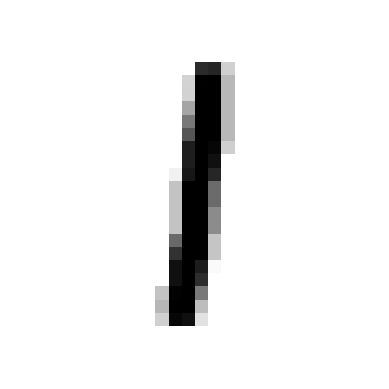

In [25]:
img_idx = np.random.randint(0, X_test.shape[0])
plt.imshow(X_test[img_idx], cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()

In [26]:
y_test[img_idx]

1

- 그러나 우리의 네트워크는 **열 벡터**만 받아들이기 때문에
- 이미지 -> 1D 벡터로 변환해서 flatten해야 한다.
    - 즉, **shape(1, 784)의 벡터**
    - 28x28 = 784이므로

In [27]:
# 중요중요
X_train, X_test = X_train.reshape(-1, 28 * 28), X_test.reshape(-1, 28 * 28)

- 픽셀 값 살펴보기
    - 이 값은 채널당 8비트(unit8)인 영상에 대한 일반 정수 값이다.
    - 그러나 일부 작업에 비해 너무 클 수 있다.
        - 예를 들어, 너무 큰 값이 주어지면 시그모이드느느 사용하는 지수 함수 때문에 nan("not a number")을 반환할 수 있으며, 이는 큰 입력값으로 "overflow"할 수 있다.
    

In [28]:
print("Pixel values between {} and {}".format(X_train.min(), X_train.max()))

Pixel values between 0 and 255


- 따라서 입력 데이터를 정규화하는 것이 일반적
    - 즉, 값을 0과 1(또는 -1과 1) 사이로 조정


In [29]:
X_train, X_test = X_train/255., X_test/255.
print("Normalized pixel values between {} and {}".format(X_train.min(), X_train.max()))

Normalized pixel values between 0.0 and 1.0


- loss를 계산하기 위해, labels을 one-hot 인코딩
    - 예를 들어, label 4를 [0, 0, 0, 1, 0, 0, 0, 0, 0]로 변환ㅡ

In [30]:
y_train = np.eye(num_classes)[y_train]

In [31]:
y_train[4]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

#### 2) Instantiating the Network

- SimpleNetwork 클래스를 사용
- 2개의 hidden layer로 네트워크를 인스턴스화
- flattened image를 입력으로 가져오기
- 이미지가 클래스 각각에 속한다는 belief를 나타내는 10-value 벡터를 반환(값이 높을수록 더 강한 belief)

In [32]:
mnist_classifier = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, hidden_layers_sizes=[64, 32])

- 우리의 네트워크 성능을 체크할 수 있다.
    - 이것의 training set에 대한 loss, test set에 대한 accuracy
    - 성능이 매우 낮지만 아직 훈련 전!

In [33]:
predictions = mnist_classifier.forward(X_train)                         # forward pass
loss_untrained = mnist_classifier.loss_function(predictions, y_train)   # loss computation

accuracy_untrained = mnist_classifier.evaluate_accuracy(X_test, y_test)  # Accuracy
print("Untrained : training loss = {:.6f} | val accuracy = {:.2f}%".format(
    loss_untrained, accuracy_untrained * 100))

Untrained : training loss = 4.436700 | val accuracy = 12.19%


#### 3) Teaching our Network to Classify

In [34]:
losses, accuracies = mnist_classifier.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=50)
# note: Reduce the batch size and/or number of epochs if your computer can't 
#       handle the computations / takes too long.
#       Remember, numpy also uses the CPU, not GPUs as modern Deep Learning 
#       libraries do, hence the lack of computational performance here.

Epoch    0: training loss = 1.096978 | val accuracy = 19.10%
Epoch   20: training loss = 0.252953 | val accuracy = 84.89%
Epoch   40: training loss = 0.177532 | val accuracy = 88.92%
Epoch   49: training loss = 0.161194 | val accuracy = 89.64%


- 시각화를 위해 training 동안 loss, accuracy의 evolution을 plot할 수 있다.

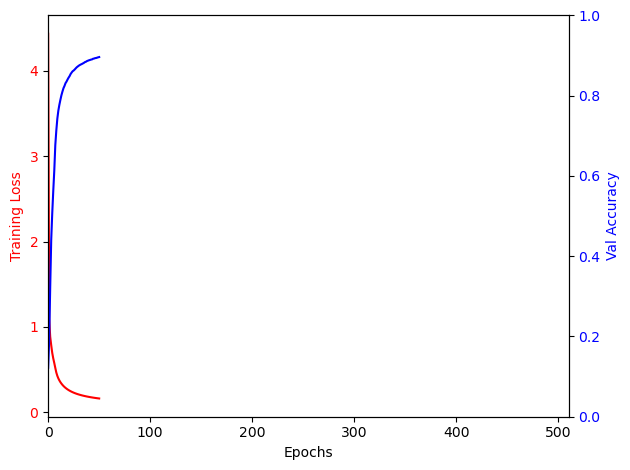

In [35]:
losses, accuracies = [loss_untrained] + losses, [accuracy_untrained] + accuracies
fig, ax_loss = plt.subplots()

color = 'red'
ax_loss.set_xlim([0, 510])
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Training Loss', color=color)
ax_loss.plot(losses, color=color)
ax_loss.tick_params(axis='y', labelcolor=color)

ax_acc = ax_loss.twinx()  # instantiate a second axes that shares the same x-axis
color = 'blue'
ax_acc.set_xlim([0, 510])
ax_acc.set_ylim([0, 1])
ax_acc.set_ylabel('Val Accuracy', color=color)
ax_acc.plot(accuracies, color=color)
ax_acc.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

- 랜덤 테스트 이미지에서 네트워크가 현재 어떻게 작동하는지 확인

In [36]:
# We use `np.expand_dims(x, 0)` to simulate a batch (transforming the image shape
# from (784,) to (1, 784)):
predicted_class = mnist_classifier.predict(np.expand_dims(X_test[img_idx], 0))
print('Predicted class: {}; Correct class: {}'.format(predicted_class, y_test[img_idx]))

Predicted class: 1; Correct class: 1
